In [20]:
!git pull https://github.com/Lolleeee/MIEEG

From https://github.com/Lolleeee/MIEEG
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [1]:
!git clone https://github.com/Lolleeee/MIEEG
import os 
os.chdir("MIEEG")

Cloning into 'MIEEG'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1077 (delta 159), reused 133 (delta 75), pack-reused 849 (from 1)
Receiving objects: 100% (1077/1077), 40.37 MiB | 18.25 MiB/s, done.
Resolving deltas: 100% (711/711), done.


In [2]:
from packages.train.training import train_model
from packages.io.file_loader import get_data_loaders
import torch
import os

from packages.data_objects.dataset import TorchDataset, CustomTestDataset

dataset_path = "/kaggle/input/0-5subset-datanooverlap"
# Dummy training loop

dataset = TorchDataset(root_folder=dataset_path, chunk_size=64)

train_loader, val_loader, _ = get_data_loaders(dataset, sets_size={'train': 0.7, 'val': 0.3, 'test': 0.}, norm_axes=(0, 1, 5), batch_size = 64)
# norm_params = train_loader.dataset.dataset._norm_params

Calculating global parameters: 100%|██████████| 87/87 [00:28<00:00,  3.05it/s]

Calculated mean shape: torch.Size([1, 25, 7, 5, 1]), std shape: torch.Size([1, 25, 7, 5, 1])


In [6]:
optimizer = torch.optim.AdamW
from packages.models.vqae import SequenceProcessor
from packages.models.vqae_skip import VQVAE
from packages.train.loss import VQVAELoss, SequenceVQVAELoss
model = SequenceProcessor(chunk_shape=(25, 7, 5, 64), embedding_dim=32, codebook_size=1024, use_quantizer=True)
model.chunk_ae = VQVAE(
    in_channels = 25,
    input_spatial=(7, 5, 64),
    embedding_dim=32,
    codebook_size=1024,
    use_skip_connections=True,
    num_downsample_stages=3,
    skip_strength=0.1)

mae = torch.nn.L1Loss
criterion = SequenceVQVAELoss(
    recon_loss_type='mse',
    recon_weight=1.0
)

config = {
    'lr': 1e-3,
    'weight_decay': 1e-3,
    'epochs': 120,
    'EarlyStopping' : {'patience': 20, 'min_delta': 0.01},
    'BackupManager': {'backup_interval': 10, 'backup_path': './model_backups'},
    'ReduceLROnPlateau': {'mode': 'min', 'patience': 40, 'factor': 0.0},
    'history_plot': {'plot_type': 'extended', 'save_path': './training_history'},
    'grad_clip': 1.0,
    'use_amp': False,
    #'grad_logging_interval' : 10,
    'asym_lr': None
}
train_model(model, train_loader=train_loader, val_loader=val_loader, loss_criterion=criterion, optimizer=optimizer, config=config, metrics={})

Epochs:   0%|          | 0/120 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.7961


KeyboardInterrupt: 

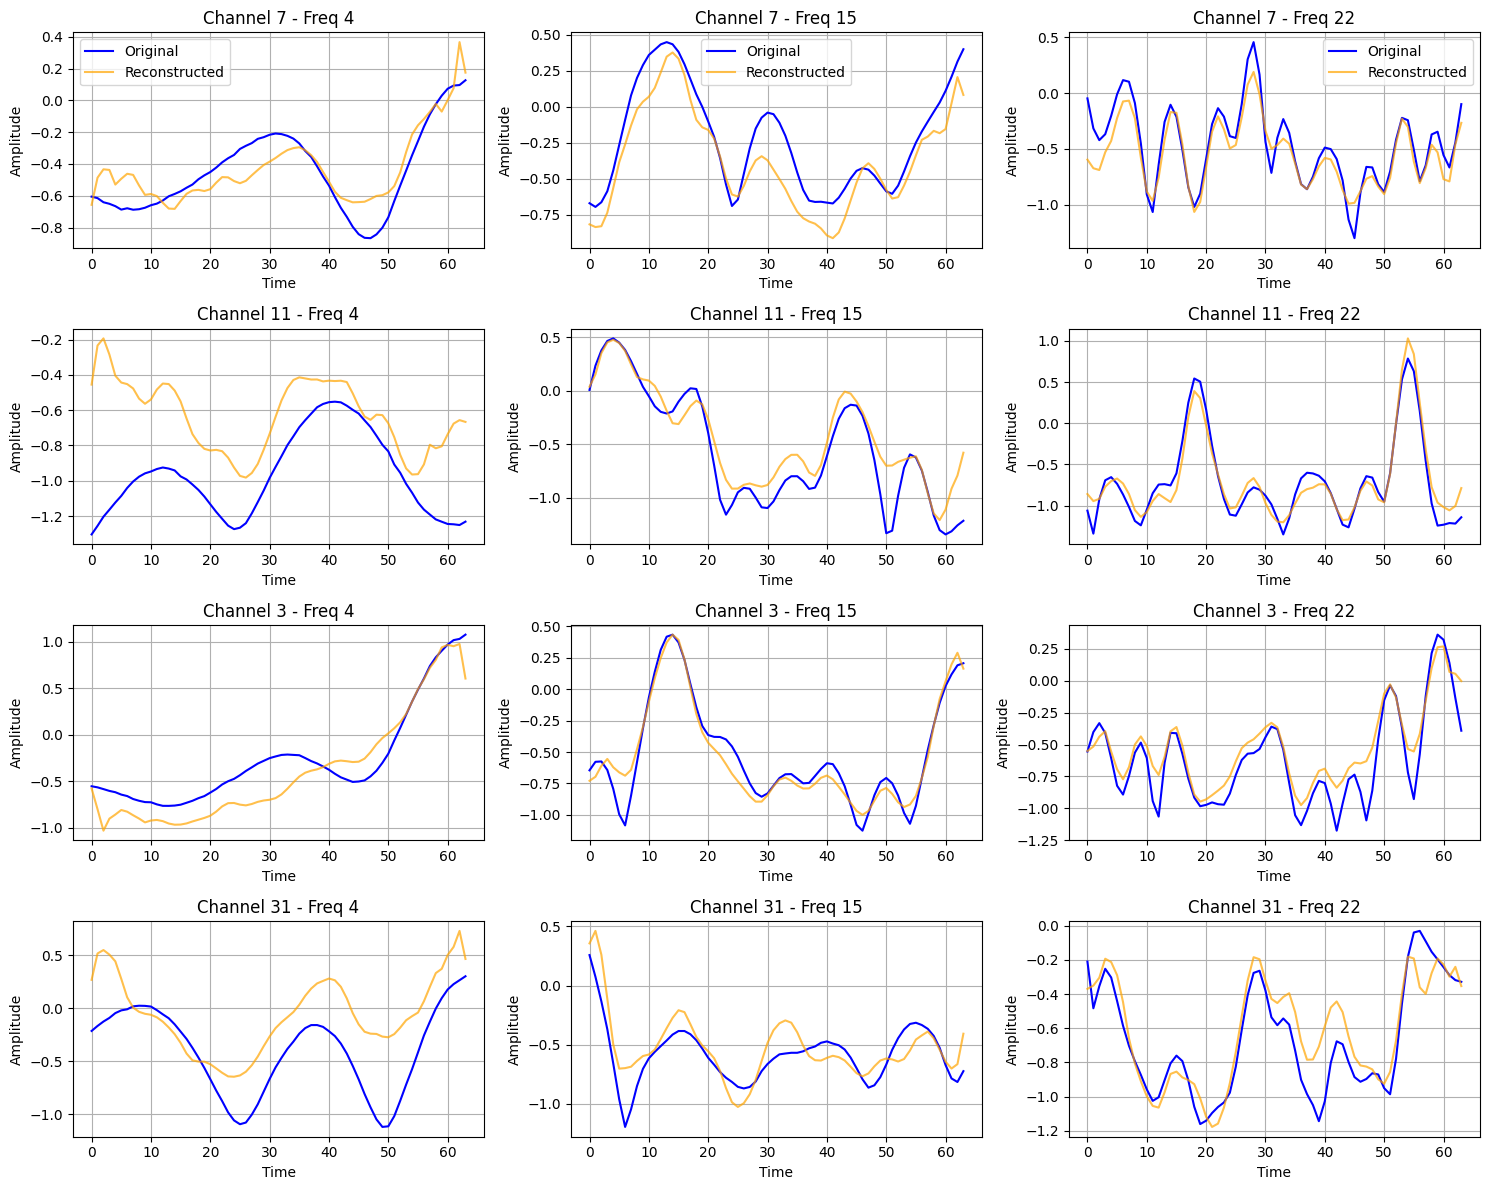

In [5]:
from packages.plotting.reconstruction_plots import plot_reconstruction_slices
import numpy as np

import torch
from packages.plotting.reconstruction_plots import plot_reconstruction_scatter

# --- Load model and parameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.load_state_dict(torch.load("/kaggle/working/MIEEG/model_backups/best_model_epoch_25.pt", map_location="cpu"))
model.eval()
# --- Prepare input data ---
input_data = next(iter(train_loader))  # Replace with your actual input
input_data = input_data.to(device)
# --- Get reconstruction ---
with torch.no_grad():
    reconstructed = model(input_data)
    if isinstance(reconstructed, tuple):
        reconstructed = reconstructed[0]

# --- Plot reconstruction scatter ---

i = np.random.randint(0, input_data.shape[0])
j = np.random.randint(0, input_data.shape[1])
plot_reconstruction_slices(input_data[i, j, ...], reconstructed[i, j, ...], freqs=[4, 15, 22])

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = VQVAE(input_spatial=(7, 5 ,64), embedding_dim=512, codebook_size=64)
model1.to(device)
for batch in train_loader:
    with torch.no_grad():
        batch = batch.to(device)
        x = batch
        z = model1.encoder(x)               # change to how you get pre-quant z
        z_flat = z.view(z.size(0), -1)
        z_std = z_flat.std(dim=1).mean().item()
        z_mean = z_flat.mean().item()

        x_std = x.view(x.size(0), -1).std(dim=1).mean().item()
        x_mean = x.view(x.size(0), -1).mean().item()

        print(f"Input Std: {x_std:.4f}, Mean: {x_mean:.4f} | Pre-Quantization Latent Std: {z_std:.4f}, Mean: {z_mean:.4f}")
        
        _, _, indices = model.vq(z)
        unique_codes = len(torch.unique(indices))
        print(f"Unique codes used: {unique_codes}/{model.vq.num_embeddings}")

Input Std: 0.8316, Mean: -0.0368 | Pre-Quantization Latent Std: 0.5912, Mean: 0.2777
Unique codes used: 60/64
Input Std: 0.9212, Mean: 0.0623 | Pre-Quantization Latent Std: 0.5911, Mean: 0.2766
Unique codes used: 59/64
Input Std: 0.8358, Mean: -0.0418 | Pre-Quantization Latent Std: 0.5915, Mean: 0.2772
Unique codes used: 60/64
Input Std: 0.8723, Mean: -0.0225 | Pre-Quantization Latent Std: 0.5909, Mean: 0.2776
Unique codes used: 61/64
Input Std: 0.8803, Mean: 0.0376 | Pre-Quantization Latent Std: 0.5918, Mean: 0.2769
Unique codes used: 58/64
Input Std: 0.8995, Mean: 0.0370 | Pre-Quantization Latent Std: 0.5914, Mean: 0.2773
Unique codes used: 57/64
Input Std: 0.8494, Mean: -0.0384 | Pre-Quantization Latent Std: 0.5917, Mean: 0.2773
Unique codes used: 58/64
Input Std: 0.8678, Mean: -0.0077 | Pre-Quantization Latent Std: 0.5918, Mean: 0.2775
Unique codes used: 62/64
Input Std: 0.8282, Mean: -0.0334 | Pre-Quantization Latent Std: 0.5910, Mean: 0.2777
Unique codes used: 61/64
Input Std: 0.

KeyboardInterrupt: 

In [30]:
from packages.train.testing import autoencoder_test_plots
autoencoder_test_plots(model, val_loader, nsamples = 5)

torch.Size([7, 10, 25, 7, 5, 25])


/kaggle/working/MIEEG/packages/train/testing.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)


TypeError: expected Tensor as element 0 in argument 0, but got tuple

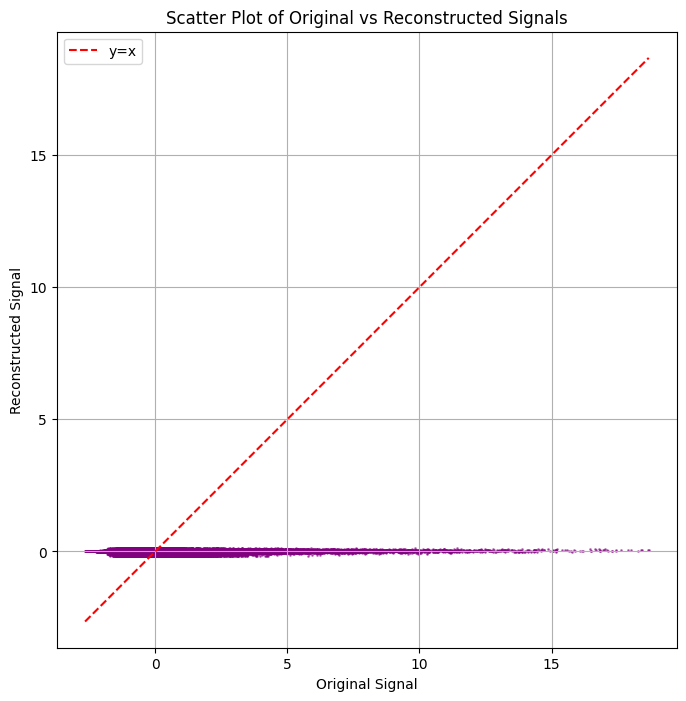

IndexError: index 30 is out of bounds for dimension 0 with size 7

In [17]:
from packages.plotting.reconstruction_plots import plot_reconstruction_slices
import numpy as np

import torch
from packages.plotting.reconstruction_plots import plot_reconstruction_scatter

# --- Load model and parameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.load_state_dict(torch.load("/kaggle/working/MIEEG/model_backups/best_model_epoch_25.pt", map_location="cpu"))
model.eval()
# --- Prepare input data ---
input_data = next(iter(val_loader))  # Replace with your actual input
input_data = input_data.to(device)
# --- Get reconstruction ---
with torch.no_grad():
    reconstructed = model(input_data)
    if isinstance(reconstructed, tuple):
        reconstructed = reconstructed[0]

# --- Plot reconstruction scatter ---
plot_reconstruction_scatter(input_data, reconstructed)

batch_size = config.get('batch_size', 31)
i = np.random.randint(0, batch_size)
if isinstance(reconstructed, tuple):
    reconstructed = reconstructed[0]
plot_reconstruction_slices(input_data[i,...], reconstructed[i,...], freqs=[4,15,22])